In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------

import admin_functions as adfn
import cell_decomp_func as cdfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
F10t2 = '/Volumes/Dominic 10tb2/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.16 (default, Jan 17 2023, 09:28:58) \n[Clang 14.0.6 ]'

## Simulate data for cell demixing

In [2]:
#Define parameters of simulated data
n_clusts = 10
n_genes = 200
n_cells = 830

#Sample random rates from a uniform distribution for each class and each gene
rate_mat = np.zeros((n_clusts, n_genes))
rate_mat = np.random.uniform(low=0, high=50, size=(rate_mat.shape)).astype(int)
cell_rate_mat = np.repeat(rate_mat, int(n_cells/n_clusts), axis=0) #get the rates for each cell - n cells in each group with same rates

#Sample from Poisson for each cell given its cell type
cell_counts = np.random.poisson(cell_rate_mat, size=cell_rate_mat.shape)

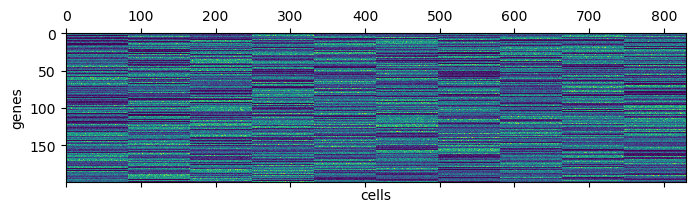

In [59]:
#visualise cell counts across all 
fig, ax = plt.subplots(figsize=(8,3))
ax.matshow(cell_counts.T)
ax.set_xlabel('cells')
ax.set_ylabel('genes')
plt.show()

In [3]:
#Generate spots
orig_cells = np.arange(0,cell_counts.shape[0]) 
random.seed(10)
random.shuffle(orig_cells) #randomly shuffle indeces

#split into n spots
chunk_size = []

for f in range(1,10):
    chunk_size = np.append(chunk_size, np.full(int(np.random.uniform(20, 60)), f)) #change random sample range to alter number of spots
    if sum(chunk_size) >= n_cells:
        break

chunk_size = chunk_size[np.cumsum(chunk_size) <= n_cells] #reduce groups to match number of cells
groups = np.split(orig_cells, np.append(np.cumsum(chunk_size), n_cells+1).astype(int))#group by chunk size
n_spots = len(groups)

In [4]:
#Create simulated spots and calculate true proportions
spots = np.zeros((len(groups), cell_counts.shape[1])) #spots x genes
prop_vec = np.zeros((len(groups),n_clusts))

#loop over each group
for g in range(len(groups)):
    spots[g] = np.sum(cell_counts[groups[g]], axis=0) #generate mix of gene expression
    prop_vec[g] = cdfn.proportions((groups[g]/int(n_cells/n_clusts)).astype(int), n_clusts) #calculate the true proportions

In [5]:
#Calculate mean gene expression per group
curr = 0
ref_exp = np.zeros((n_clusts, n_genes))
for i in range(n_clusts):
    ref_exp[i] = np.mean(cell_counts[curr:curr+int(n_cells/n_clusts),:], axis=0)
    curr+=int(n_cells/n_clusts)

# pyRCTD_GP
* Python implementation of RCTD with Gaussian processes

In [224]:
def proportions(inp, n_clusts):
    props = np.zeros(n_clusts)
    prac = prac = np.unique(inp, return_counts=True)
    partial_props = prac[1]/sum(prac[1])
    count=0
    for o in range(len(props)):
        if o in prac[0]: 
            props[o] = partial_props[count]
            count+=1
    return(props)

In [225]:
n_clusts = 10
n_genes = 500 
n_cells = 600

#Sample random rates from a uniform distribution for each class and each gene
rate_mat = np.zeros((n_clusts, n_genes)) 
rate_mat = np.random.uniform(low=0, high=50, size=(rate_mat.shape)).astype(int) 
cell_rate_mat = np.repeat(rate_mat, 60, axis=0) #get the rates for each cell - 60 cells in each group with same rates #?

#Sample from Poisson for each cell given its cell type
cell_counts = np.random.poisson(cell_rate_mat, size=cell_rate_mat.shape)


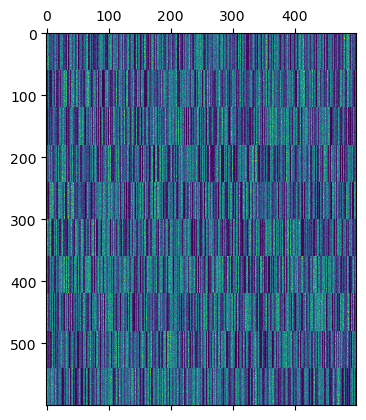

(600, 500)


In [128]:
plt.matshow(cell_counts)
plt.show()
print(cell_counts.shape)

In [141]:
#Generate spots
n_spots = 200

orig_cells = np.arange(0,cell_counts.shape[0]) 
#random.seed(10)
random.shuffle(orig_cells) #randomly shuffle indeces

#Define partioning - split into different groups of varying sizes
chunk_size = [np.ones(50), np.full(40, 2), np.full(47, 3), np.full(1, 4), np.full(61, 5)] #???
groups = np.split(orig_cells, np.cumsum(np.concatenate(chunk_size)).astype(int)) #group by chunk size

In [228]:
#Generate spots
n_spots = 180

orig_cells = np.arange(0,cell_counts.shape[0]) 
#random.seed(10)
random.shuffle(orig_cells) #randomly shuffle indeces

#change same number of groups as spots - match 200, re-run
#Define partioning - split into different groups of varying sizes
chunk_size = [np.ones(50), np.full(20, 2), np.full(27, 3), np.full(1, 4), np.full(61, 5), np.full(20,6)]
groups = np.split(orig_cells, np.cumsum(np.concatenate(chunk_size)).astype(int)) #group by chunk size
len(groups)

180

In [230]:
#Create simulated spots and calculate true proportions
spots = np.zeros((len(groups), cell_counts.shape[1])) #spots x genes
prop_vec = np.zeros((len(groups),n_clusts))

#loop over each group
for g in range(len(groups)):
    spots[g] = np.sum(cell_counts[groups[g]], axis=0) #generate mix of gene expression
    prop_vec[g] = proportions((groups[g]/60).astype(int), n_clusts) #calculate the true proportions

In [231]:
#Calculate mean gene expression per group
curr = 0
ref_exp = np.zeros((n_clusts, n_genes))
for i in range(n_clusts):
    ref_exp[i] = np.mean(cell_counts[curr:curr+60,:], axis=0)
    curr+=60

In [233]:
#Run without logs
basic_model=pm.Model()

with basic_model:
    
    # alpha=pm.MvNormal("alpha", mu=0, cov=np.ones((200,200)), shape=(200,50))
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    
    lmd=pm.math.dot(beta, ref_exp)    

    #Calculate total counts to get Poisson rates
    N = np.sum(spots+1, axis=1) 
    N = np.asarray([N for i in range(n_genes)]).T #Repeat total counts across columns for elementwise multiplication

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots+1)
    

In [234]:
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 217 seconds.


In [ ]:
groups

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

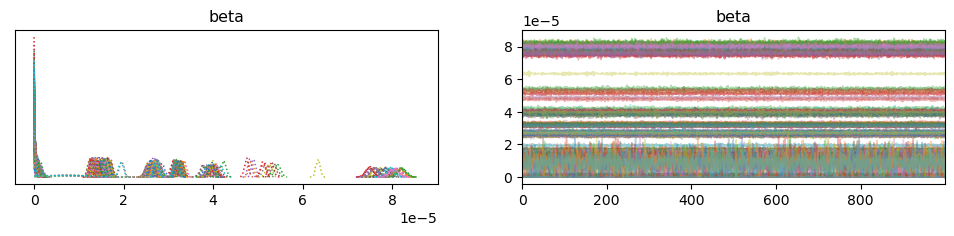

In [235]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

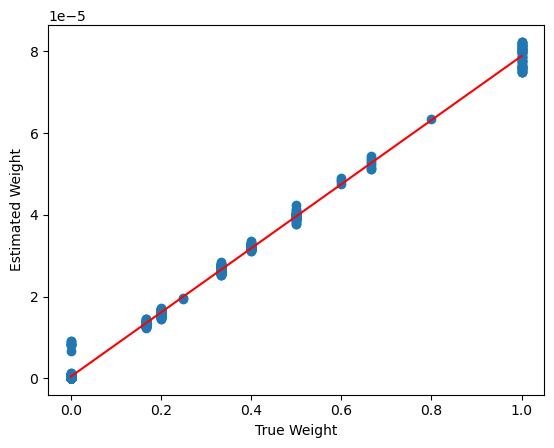

In [236]:
from scipy.stats import linregress
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

# Bayesian inference with PyMC

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [34]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

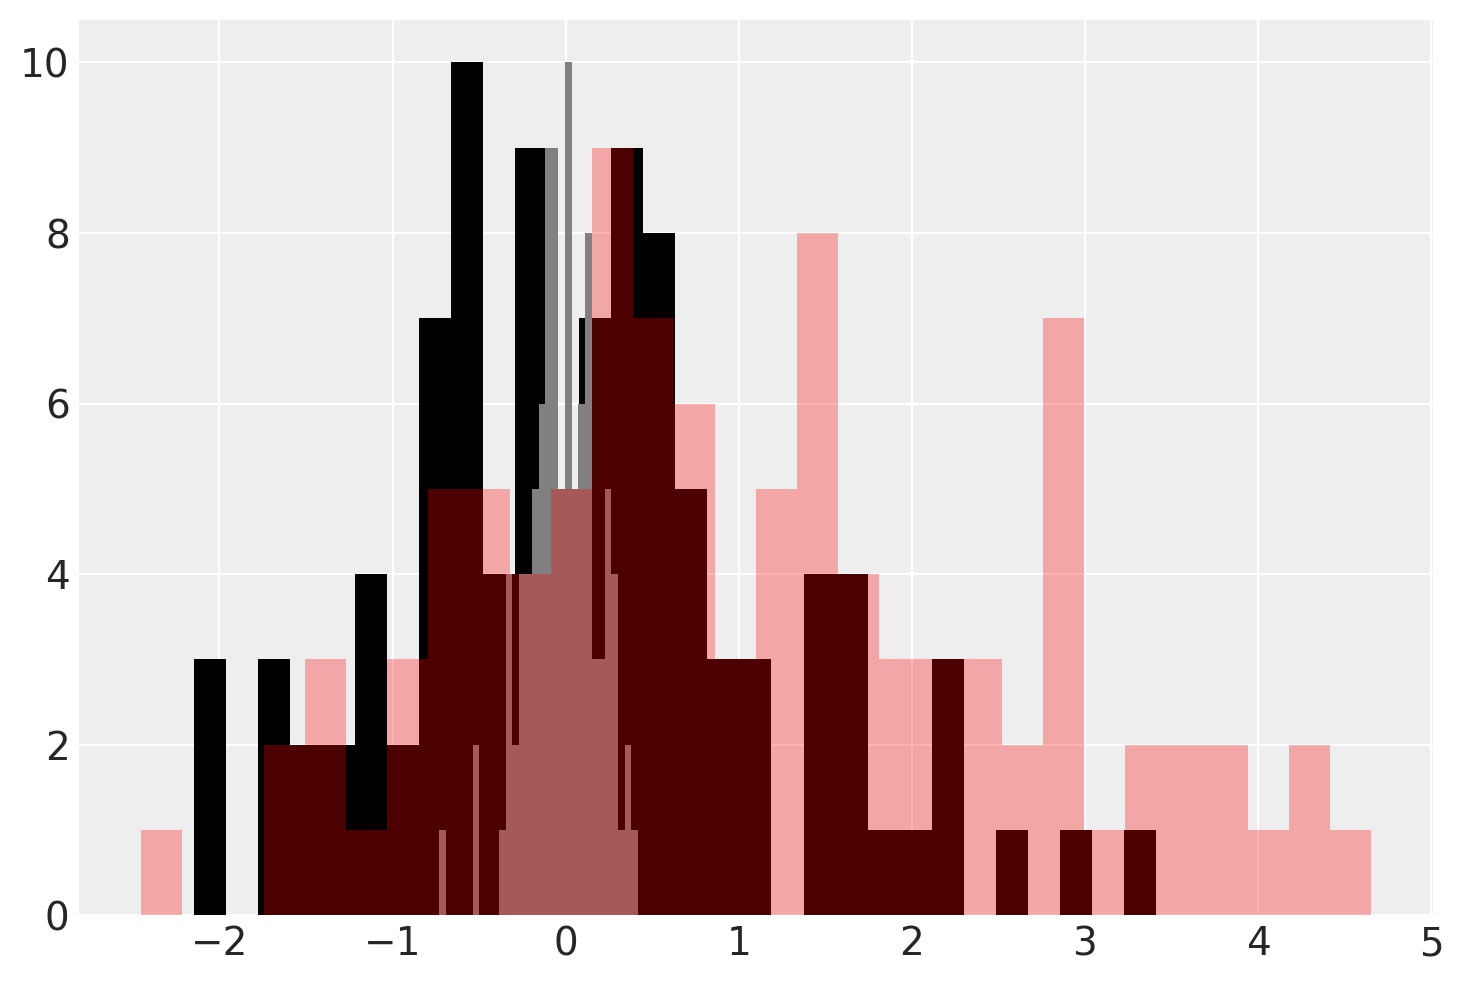

In [35]:
nbins = 30
plt.hist(X1, color='k', bins = nbins)
plt.hist(X2, color='grey', bins = nbins)
plt.hist(Y, color='red', bins = nbins, alpha = 0.3)

plt.show()

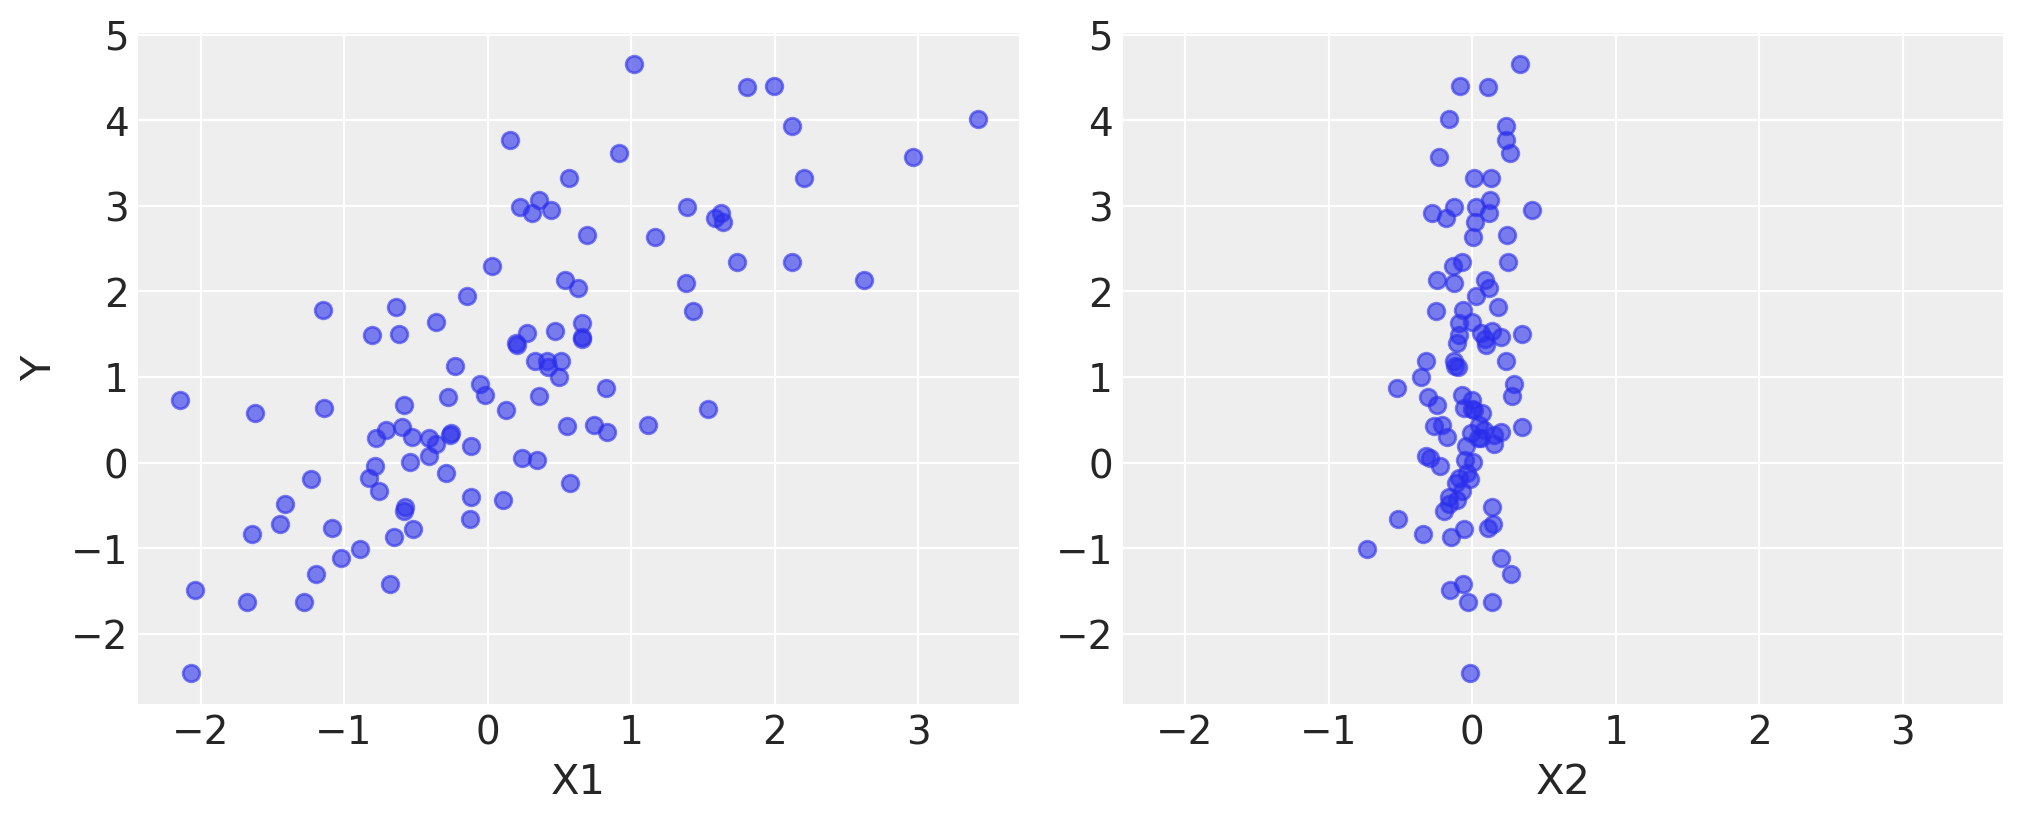

In [36]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [ ]:
basic_model = pm.Model()

with basic_model: #Creates new model object

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=5, sigma=1)
    beta = pm.Normal("beta", mu=5, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

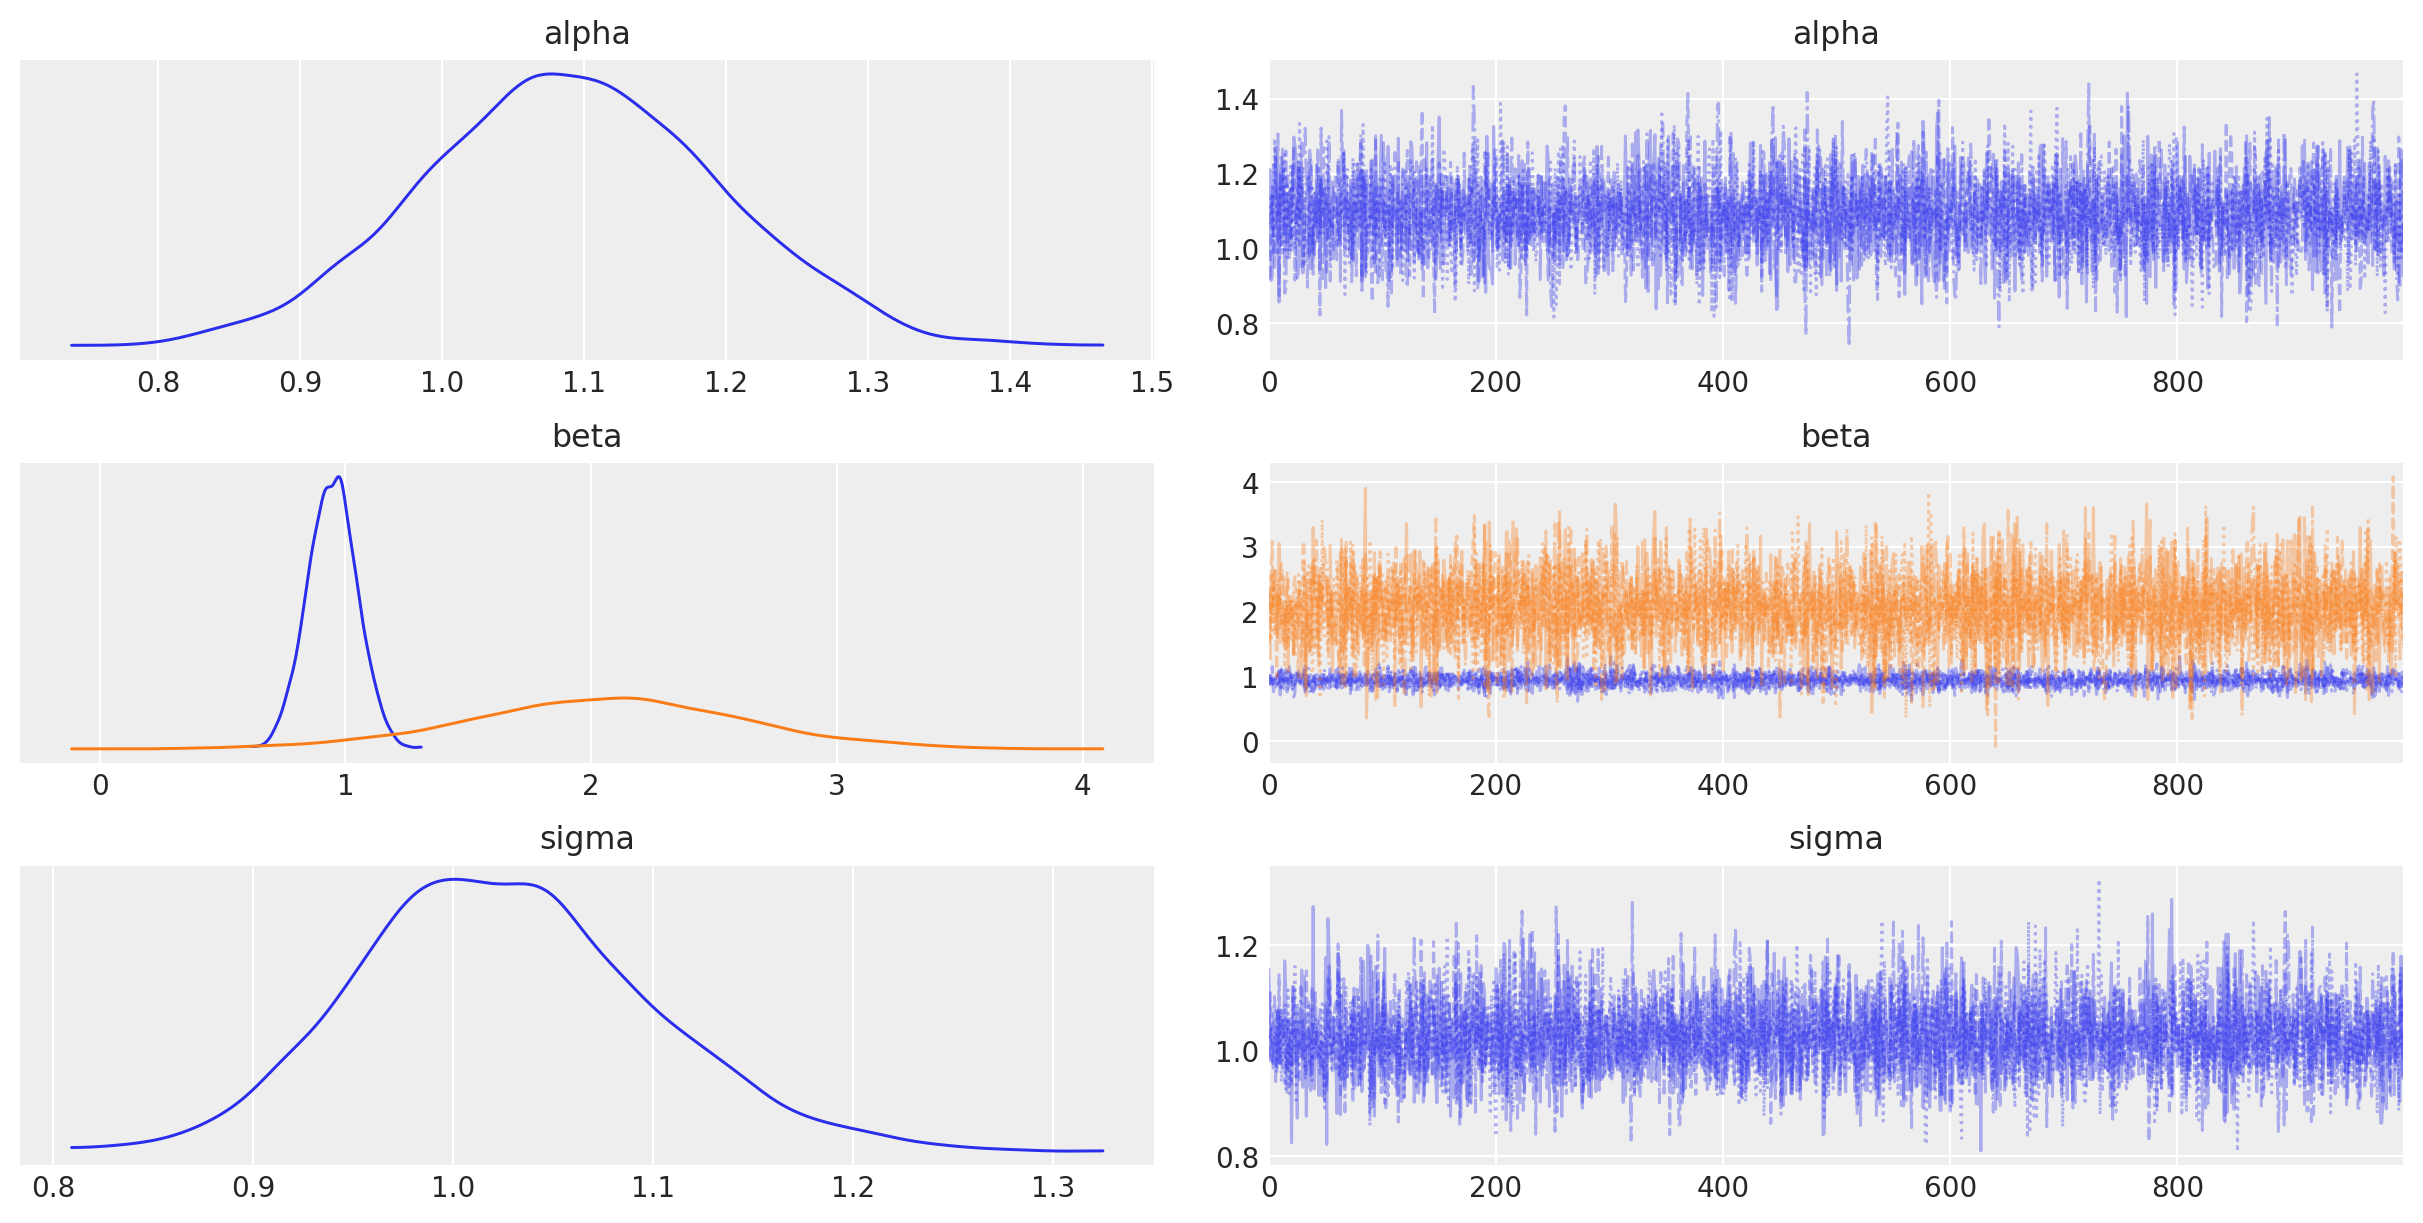

In [71]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata, combined=True);

# Apply to neuronal activity data

In [4]:
data_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regtrace*')
data_l

['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04

In [6]:
prac = np.load(data_l[0])
prac.shape

(15105, 4914)

In [25]:
Y = prac[0]
Y.shape

(4914,)

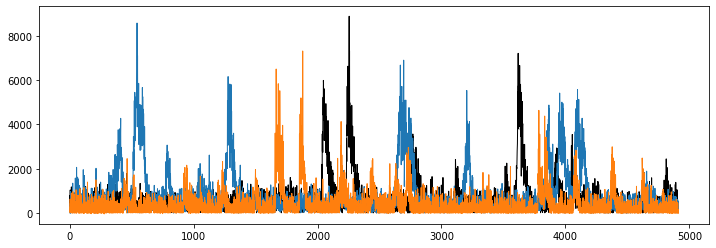

In [26]:
fig, axarr = plt.subplots(figsize = (12,4))
for i in range(3):
    if i ==0:
        plt.plot(prac[i], linewidth = 1, c = 'k')
    else:
        plt.plot(prac[i], linewidth = 1)

In [30]:
u  = np.mean(prac)

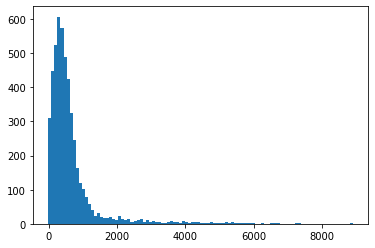

In [27]:
plt.hist(Y, bins = 100)
plt.show()

In [32]:
X1 = prac[1]
X2 = prac[2]
X1.shape, X2.shape, Y.shape

((4914,), (4914,), (4914,))

In [52]:
basic_model = pm.Model()

with basic_model: #Creates new model object

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=200, sigma=10)
    beta = pm.Normal("beta", mu=1, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [44]:
basic_model

In [53]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()


/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


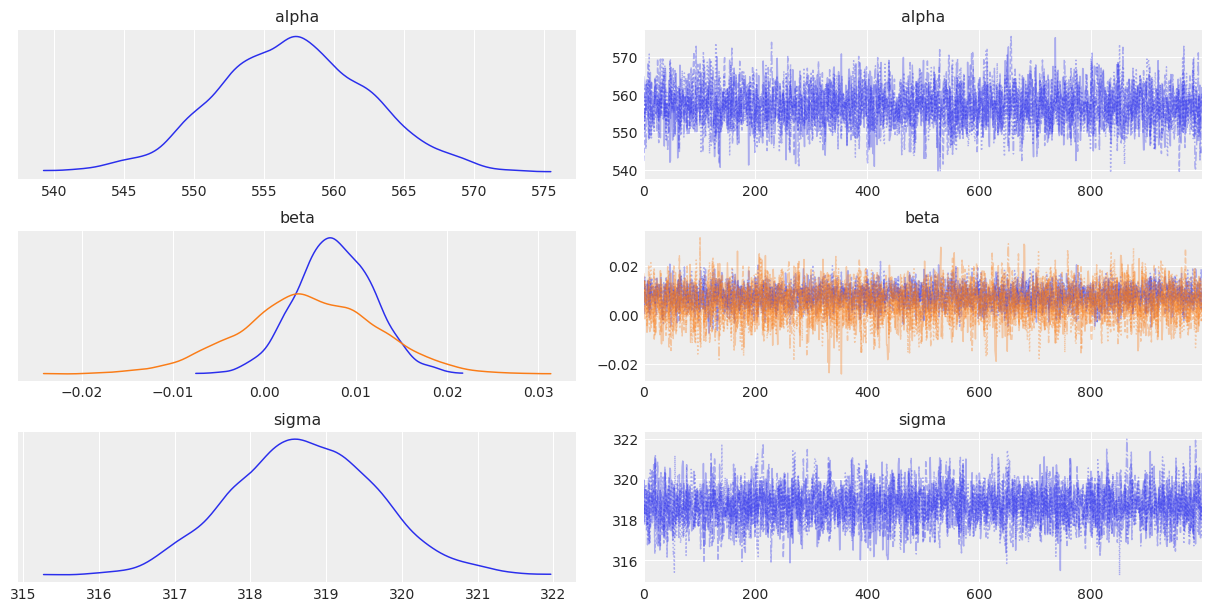

In [54]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata, combined=True);

# Gaussian processes

In [40]:
from gp import GP, SquaredExponentialKernel
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set values to model parameters.
lengthscale = 0.1
signal_variance = 10.
noise_variance = 0.1

# Create the GP.
kernel = SquaredExponentialKernel(
    lengthscale=lengthscale, signal_variance=signal_variance)
gp = GP(kernel=kernel, noise_variance=noise_variance)
n = 200
x = np.linspace(0, 2 * np.pi, n)
mean = np.zeros(n)
cov = gp.k(x, x)

# Draw samples from the GP prior.
probabilities = []
samples = []
jitter = np.eye(n) * 1e-6
for _ in range(20):
    y = multivariate_normal.rvs(mean=mean, cov=cov)
    # Add a jitter to the covariance matrix for numerical stability.
    prob = multivariate_normal.pdf(y, mean=mean, cov=cov + jitter)

    samples.append(y)
    probabilities.append(prob)

# Normalize sample probabilities into [0, 1].
probabilities = np.array(probabilities)
min_prob, max_prob = np.min(probabilities), np.max(probabilities)
probabilities = (probabilities - min_prob) / (max_prob - min_prob)
# Plotting.
ax = plt.gca()
for y, prob in zip(samples, probabilities):
    ax.plot(x, y, alpha=prob * 2)

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

plt.show()


SyntaxError: invalid syntax (gp.py, line 105)

In [39]:
gp.k?

Object `gp.k` not found.


In [38]:
np.cov(x, x)

array([[3.33963029, 3.33963029],
       [3.33963029, 3.33963029]])

In [29]:
#from gp import GP, SquaredExponentialKernel
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set values to model parameters.
lengthscale = 0.1
signal_variance = 10.
noise_variance = 0.1

# Create the GP.

n = 200
x = np.linspace(0, 2 * np.pi, n)
mean = np.zeros(n)
#cov = gp.k(x, x)


In [32]:
len(x), mean

(200,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [33]:

# Draw samples from the GP prior.
probabilities = []
samples = []
jitter = np.eye(n) * 1e-6
for _ in range(20):
    y = multivariate_normal.rvs(mean=mean, cov=cov)
    # Add a jitter to the covariance matrix for numerical stability.
    prob = multivariate_normal.pdf(y, mean=mean, cov=cov + jitter)

    samples.append(y)
    probabilities.append(prob)


NameError: name 'cov' is not defined

In [34]:
y = multivariate_normal.rvs?

Signature: multivariate_normal.rvs(mean=None, cov=1, size=1, random_state=None)
Docstring:
Draw random samples from a multivariate normal distribution.

Parameters
----------
mean : array_like, optional
    Mean of the distribution (default zero)
cov : array_like, optional
    Covariance matrix of the distribution (default one)
allow_singular : bool, optional
    Whether to allow a singular covariance matrix.  (Default: False)
size : integer, optional
    Number of samples to draw (default 1).
random_state : {None, int, `numpy.random.Generator`,
                `numpy.random.RandomState`}, optional

    If `seed` is None (or `np.random`), the `numpy.random.RandomState`
    singleton is used.
    If `seed` is an int, a new ``RandomState`` instance is used,
    seeded with `seed`.
    If `seed` is already a ``Generator`` or ``RandomState`` instance then
    that instance is used.

Returns
-------
rvs : ndarray or scalar
    Random variates of size (`size`, `N`), where `N` is the
    dime

In [ ]:
y = multivariate_normal.rvs